# Approximating a Function using Deep Learning

In this notebook, we will generate data according to some mathematical function, and then attempt to use Deep Learning, more specifically, neural networks to approximate that function

Finally, we will show how to save this model to your DSX Local filesystem to be used for online scoring.





## Table of Contents
This notebook contains these main sections:

1. [Import Libraries](#Import_Libraries)
2. [Generate Data](#Generate_Data)
3. [The Model](#The_Model)
4. [Model Evaluation](#Model_Evaluation)
5. [Save Model to DSX Filesystem](#Save_Model_to_DSX_Filesystem)
6. [Summary](#Summary)

<a id='Import_Libraries'></a>
## Import Libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

<a id='Generate_Data'></a>
## Generate Data
First, we will generate data according to some mathematical function:

$F(x,y) = \begin{cases} 
      0 & \sin(x)+cos(y) < -1 \\
      1 & -1 \leq \sin(x)+cos(y) < 0 \\
      2 & 0 \leq \sin(x)+cos(y) < 1 \\
      3 & \sin(x)+cos(y) \geq 1
   \end{cases}$
   
Where $x$ and $y$ are both values between $0$ and $10$ exclusive

In [3]:
x = (10*np.random.rand(10**5))
y = (10*np.random.rand(10**5))

df = pd.DataFrame({'X':x,'Y':y})

We will define a function that will determine $F(x,y)$ as defined above

In [4]:
def determine_z(row):
    value = float(np.sin(row['X']) + np.sin(row['Y']))
    if value < -1.0:
        return 0
    if (value >= -1.0) & (value < 0.0):
        return 1
    if (value >= 0.0) & (value < 1.0):
        return 2
    if value >= 1.0:
        return 3

Now we can apply `determine_z` across our dataframe

In [5]:
df['Z'] = df.apply(determine_z, axis=1)

Let's print the head of `df` to see what our data looks like

In [6]:
df.head(10)

,X,Y,Z
0,8.617671,9.292217,2
1,1.107391,1.458697,3
2,5.323391,7.723319,2
3,1.467658,1.603683,3
4,0.539501,7.563905,3
5,5.437830,1.284024,2
6,9.771229,9.597648,1
7,7.597469,2.652242,3
8,2.948739,0.969558,3
9,3.533886,0.683955,2


From the table, we can see that we indeed have 4 classes (between 0 and 3) that correspond to the function that we defined. It would be easier to visualize this from a plot, which we will make now.

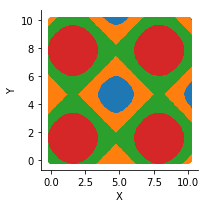

In [7]:
fg = sns.FacetGrid(df, hue='Z')
fg.map(plt.scatter, 'X', 'Y')
plt.show()

<a id='The_Model'></a>
## The Model
Let's first split the data into training and testing sets.

In [8]:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html 
X_train, X_test, y_train, y_test = train_test_split(df[['X','Y']],df['Z'])

We will fit a **Keras Sequential** model. `Keras` is a wrapper library for low level deep learning libraries such as `Tensorflow`. We will use the Keras framework as a front end, and use the Tensorflow library as a backend.

In [9]:
model = Sequential([
    Dense(12, input_dim=2),
    Dense(12, activation='relu'),
    Dense(10, activation='sigmoid'),
    Dense(8, activation='relu'),
    Dense(4, activation='softmax'),
])

Our model has 5 layers in the neural network. The first layer requires an `input_dim` parameter, which denotes the number of input features. Our final layer uses the `softmax` function, which is used primarily in categorical predictions such that the predicted values approximate a probability distribution: https://en.wikipedia.org/wiki/Softmax_function. We also denote that we are looking for 4 categories (between 0 and 3, as we defined in the function) 



In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The above cell denotes that we will be using the `adam` optimizer, a fairly well-known and efficient optimizer, along with the `categorical_crossentropy` loss, as we are predicted a multiclass output. We will use the accuracy score metric to evaluate how our model performs during each training epoch.

In [11]:
y_classes = keras.utils.to_categorical(y_train, num_classes=4)

The above cell converts our single column output vector into a 4 column vector, one column for each predicted output. This will allow Keras to assign predicted probabilities to each class, ultimately selected the most probable class for its prediction.

In [12]:
model.fit(X_train.values,y_classes, epochs=99, batch_size=1000, verbose=0)
model.fit(X_train.values,y_classes, epochs=1, batch_size=1000, verbose=2)

Epoch 1/1
0s - loss: 0.2491 - acc: 0.9069


<a id='Model_Evaluation'></a>
## Model Evaluation
We can run a few evaluation metrics on our model before creating a plot to visualize the model's effectiveness at approximating the function. We will use the `accuracy_score` and `confusion_matrix` metrics

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

Let's predict on X_test

In [14]:
y_pred = model.predict(X_test.as_matrix())
y_pred

array([[  2.78398073e-12,   4.36782982e-04,   1.52033821e-01,
          8.47529411e-01],
       [  3.22633241e-05,   5.61890423e-01,   4.38066274e-01,
          1.10699766e-05],
       [  2.93332389e-13,   1.21147517e-04,   6.35037348e-02,
          9.36375201e-01],
       ..., 
       [  2.27945770e-06,   9.95011687e-01,   4.98602074e-03,
          8.38662202e-13],
       [  4.36225116e-01,   5.63610435e-01,   1.64383353e-04,
          6.09654833e-08],
       [  2.45960146e-01,   7.54036844e-01,   2.98376654e-06,
          1.77290709e-15]], dtype=float32)

In [15]:
y_test.values

array([3, 1, 3, ..., 1, 0, 1])

Recall that our y_test values just denoted the actual class. We will need to apply an `argmax` function to our predicted values to determine the most probable class

In [16]:
predicted_classes = pd.DataFrame(y_pred).apply(np.argmax, axis=1)
predicted_classes.values

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


array([3, 1, 3, ..., 1, 1, 1])

Now we can compare the two arrays

In [17]:
accuracy_score(y_test,predicted_classes)

0.90464

In [18]:
confusion_matrix(y_test, predicted_classes)

array([[2094,  152,    1,    0],
       [  55, 5841,  549,    0],
       [   0,  693, 7824,  467],
       [   0,    0,  467, 6857]])

From the confusion matrix, we can tell that the model sometimes confused between classes up to 1 unit away (for example, the model predicted class 3, when the actual class was 2). However, we never observe the model incorrectly predicting the classes 2 or more units away. This suggests a very powerful model.

### Plots
Let's plot a similar color-coded scatterplot comparing the true classes and the predicted classes. First let's make a DataFrame.

In [19]:
test_data = X_test.copy()
test_data['Z_true'] = y_test.values
test_data['Z_pred'] = predicted_classes.values

The true function:

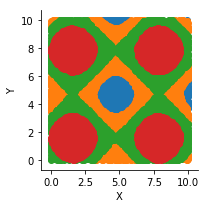

In [20]:
fg = sns.FacetGrid(test_data, hue='Z_true')
fg.map(plt.scatter, 'X', 'Y')
plt.show()

The neural network approximated function:

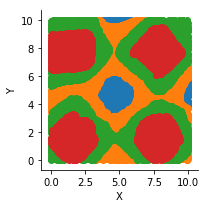

In [21]:
fg = sns.FacetGrid(test_data, hue='Z_pred')
fg.map(plt.scatter, 'X', 'Y')
plt.show()

Not bad at all! The neural network has come very close to approximating the true function.

<a id='Save_Model_to_DSX_Filesystem'></a>
## Save Model to DSX Filesystem
We can now save `Keras` model to the DSX filesystem for publishing, scoring, deployment, and evaluations. First, import the `save` function from the `dsx_ml.ml` library. The save function takes a few arguments which are listed below.

In [22]:
from dsx_ml.ml import save

ImportError: No module named 'dsx_ml'

Now we can save both the June 21 and December 21 models.

In [ ]:
save(model = model,
     name = 'CategoricalTrig',
     x_test = X_test,
     y_test = pd.DataFrame(y_test),
     algorithm_type = 'Classification')

### Model Metadata
The model will be stored in the models directory in your DSX Project. Each model is stored as a directory, in which the model artifact and metadata are stored. The metadata is stored as a JSON file, which we can open and display.

In [ ]:
import json
import os

proj_dir = os.environ['DSX_PROJECT_DIR']

with open('{}/models/CategoricalTrig/metadata.json'.format(proj_dir),'r') as infile:
    metadata_dict = json.load(infile)

print("Runtime: {}".format(metadata_dict['runtime']))
print("Model Type: {}".format(metadata_dict['type']))
print("Algorithm: {}".format(metadata_dict['algorithm']))

print("Feature(s):")
for feature in metadata_dict['features']:
    print('    '+feature['name'])

print("Latest Model Version: {}".format(metadata_dict['latestModelVersion']))
print("Label(s):")
for label in metadata_dict['labelColumns']:
    print('    '+label['name'])

<a id='Summary'></a>
## Summary
In this notebook you learned how to create a `Keras` model, evaluate the model numerically and graphically, and save the model in the DSX local environment.

<div class="alert alert-block alert-info">Note: To save resources and get the best performance please use the code below to stop the kernel before exiting your notebook.</div>

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<hr>
Copyright &copy; IBM Corp. 2017. Released as licensed Sample Materials.